# Descent Them All

This tutorial is movitated by [Lecture: Optimisation](https://www.youtube.com/watch?v=--NZb480zlg&list=PLLHTzKZzVU9eaEyErdV26ikyolxOsz6mq&index=8)


### Problem $$
\begin{equation}
    \mathcal{L}_D (\mathbf{w}) = \frac{1}{|D|} \sum_{(\mathbf{x},y) \in D} \ell (h(\mathbf{x};\mathbf{w}),y),
\end{equation}
$$

## Gradient Descent $$\begin{equation}
    \mathbf{w}_{t+1} = \mathbf{w}_t - \eta \; \frac{1}{|D|} \sum_{(\mathbf{x},y) \in D} \nabla_\mathbf{w} \; \ell (h(\mathbf{x};\mathbf{w}_t),y)=
    \mathbf{w}_t - \eta \;\nabla_{\mathbf{w}} \mathcal{L}_D (\mathbf{w}_t),
\end{equation}$$

Robbins and Monro, 1951

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.datasets import make_regression 
from mpl_toolkits.mplot3d import Axes3D
import time

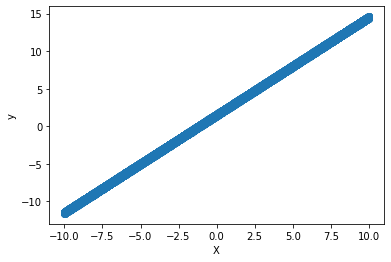

In [2]:
%matplotlib inline
N=1_000_000
X = np.linspace(-10,10,N)
# True model
y= 1.3*X + 1.5
mu,sigma=0.0,0.05 # zero mean and constant variance
y+= np.random.normal(loc=mu, scale=sigma, size=N)
plt.plot(X,y, 'o', alpha=0.5)
plt.xlabel('X'),plt.ylabel('y');

In [3]:
# standard computation in regression problem
def predict(X,w):
    return X@w
def residual_error(y,y_hat):
    return y-y_hat
def L(residual_error):
    return np.mean(residual_error**2)
def dLdw(residual_error,X):
    return (residual_error[:, None].T @ X).T/len(X)

In [4]:
%matplotlib notebook
def visualize(Xaug,y,all_losses,all_weights,title):
    
    max_w1,min_w1=max(all_weights[:,0]),min(all_weights[:,0])
    max_w2,min_w2=max(all_weights[:,1]),min(all_weights[:,1])

    # Create meshgrid of weights
    W1, W2 = np.meshgrid(np.linspace(min_w1*2, max_w1*2, 20), 
                         np.linspace(min_w2*2, max_w2*2, 20))
    # Create loss_surface
    C = np.array([[L(residual_error(y, predict(Xaug, _)))] for _ in zip(np.ravel(W1), np.ravel(W2))]).reshape(W1.shape)
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(W1, W2, C,rstride=1, cstride=1, color='b', alpha=0.2)
    ax.set_xlabel('w1', labelpad=30, fontweight='bold')
    ax.set_ylabel('w2', labelpad=30, fontweight='bold')
    ax.set_zlabel('L', labelpad=30, fontweight='bold')
    ax.plot(all_weights[:,0], all_weights[:,1], all_losses, markeredgecolor='b', marker='.')
    ax.plot(all_weights[:,0][0], all_weights[:,1][0], all_losses[0], markeredgecolor='r', marker='o',label='Start')
    ax.plot(all_weights[:,0][-1], all_weights[:,1][-1], all_losses[-1], markeredgecolor='r', marker='x',label='End')
    plt.title(title)
    #plt.savefig(f"{title}.pdf", bbox_inches='tight')
    plt.legend()
    plt.show()

# Full Gradient Descent

<IPython.core.display.Javascript object>


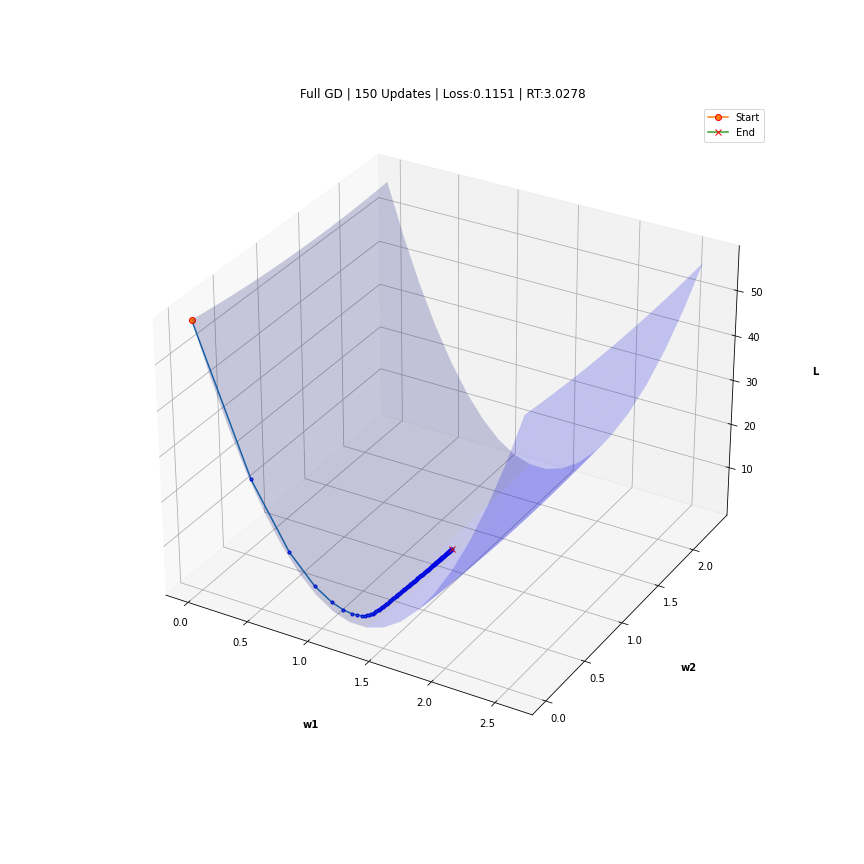

In [5]:
def full_gradient_descent(Xaug,w,num_update,lr):
    start_time=time.time()
    all_losses=[]
    all_weights=[]
    all_predicitons= []
    for i in range(num_update):
        # 1. Compute predicitons of shape N
        pred=predict(Xaug,w).flatten()
        # 2. Compute residual errors of shape N
        error=residual_error(pred,y)
        # 3. Compute loss; mean squared of residual errors.
        loss = L(error)# scalar
        # 4. Compute gradient of te loss w.r.t. weights. # shape d
        dw = dLdw(error,Xaug)
        # 5. Store data.
        all_losses.append(loss)
        all_predicitons.append(pred)
        all_weights.append(w.flatten())
        # 6. Update weights in the direction of the negative gradient. 
        w -= lr * dw
    rt=f"{time.time()- start_time:.4f}"
    return np.array(all_losses),np.array(all_weights),rt

# Global params
lr=.01 # learning rate gamma in the formula
num_update= 150 # How many times weights are updated
batch_size= len(X) # number of data points used at weight update

Xaug=np.column_stack((X,np.ones(X.shape)))
all_losses,all_weights,rt= full_gradient_descent(Xaug=Xaug,
                                                 w=np.array([[0.0],[0.0]]),
                                                 num_update=num_update,lr=lr)
visualize(Xaug,y,all_losses,all_weights,f'Full GD | {num_update} Updates | Loss:{all_losses[-1]:.4f} | RT:{rt}')

<IPython.core.display.Javascript object>


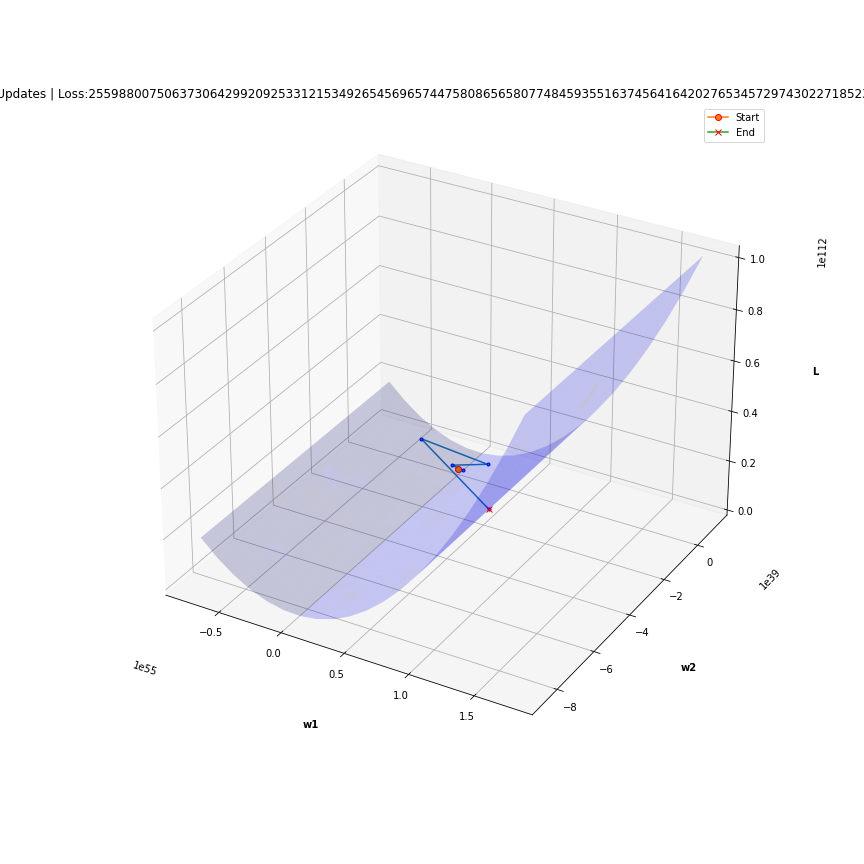

In [6]:
lr=.1 
batch_size= len(X) # number of data points used at weight update
all_losses,all_weights,rt= full_gradient_descent(Xaug,np.array([[0.0],[0.0]]),num_update=num_update,lr=lr)
visualize(Xaug,y,all_losses,all_weights,f'Full GD Divergence | {num_update} Updates | Loss:{all_losses[-1]:.4f} | RT:{rt}')

# Stochastic Gradient Descent

## $$ \begin{equation}
    \mathbf{w}_{t+1} = \mathbf{w}_{t} - \eta \nabla_{\mathbf{w}} \ell(h(\mathbf{x}_t);\mathbf{w}_t,y_t)
\end{equation}$$


## $$ \begin{equation}
    \mathbf{w}_{t+1} = \mathbf{w}_{t} - \eta \nabla_{\mathbf{w}} \ell (w_t)
\end{equation}$$

where $t$ choosen uniformly at random. 


$$ \mathbb E [ \nabla \ell_t (w_t)] = \nabla \mathcal{L}_D (w_t)$$


$$ \mathbb E [ w_{k+1})] = w_k - \nabla_k \mathcal{L}_D(w_k)$$


[It is useful to think of SGD as GD with noise](https://www.youtube.com/watch?v=--NZb480zlg&list=PLLHTzKZzVU9eaEyErdV26ikyolxOsz6mq&index=8)

# Mini-batch SGD 

## $$ \begin{equation}
    \mathbf{w}_{t+1} = \mathbf{w}_{t} - \eta \nabla_{\mathbf{w}} \mathcal{L}_B(w_t)
\end{equation}$$

where $B$ consitst of several (say 256) $t$ choosen uniformly at random. 


<IPython.core.display.Javascript object>


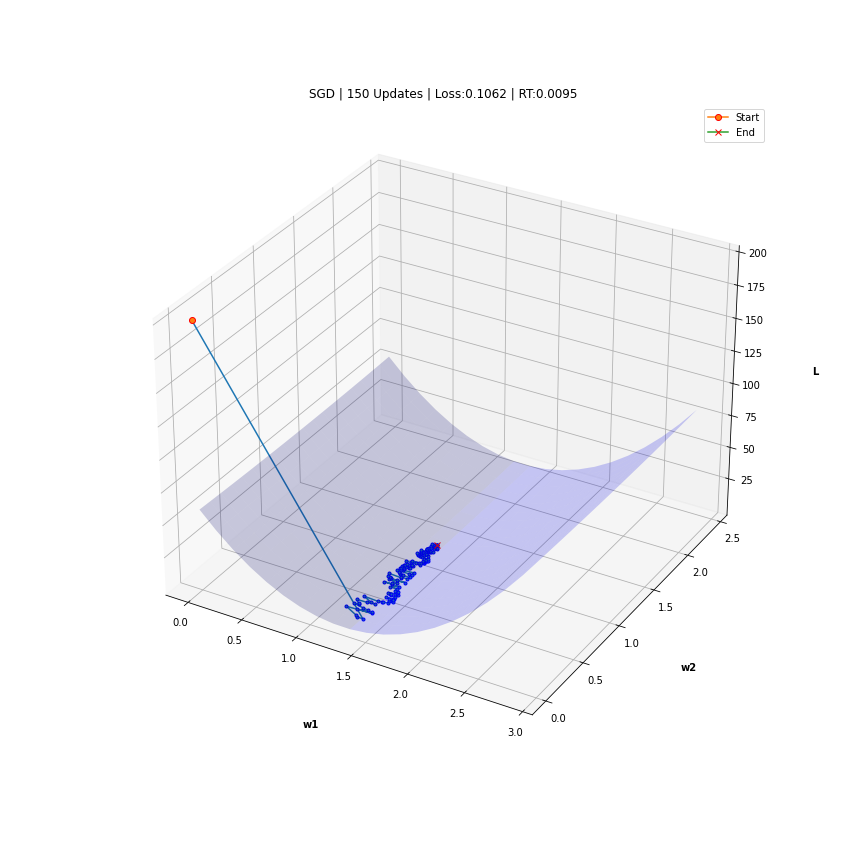

In [7]:
np.random.seed(0)
def stoachastic_gradient_descent(Xaug,w,batch_size,num_update,lr):
    start_time=time.time()
    all_losses,all_weights,all_predicitons=[],[],[]
    N=len(Xaug)
    for i in range(num_update):
        # 1. Select random samples
        idx=np.random.randint(N, size=batch_size)
        # 1. Compute predicitons of shape N
        pred=predict(Xaug[idx],w).flatten()
        # 2. Compute residual errors of shape N
        error=residual_error(pred,y[idx])
        # 3. Compute loss; mean squared of residual errors.
        loss = L(error)# scalar
        # 4. Compute gradient of te loss w.r.t. weights. # shape d
        dw = dLdw(error,Xaug[idx])
        # 5. Store data.
        all_losses.append(loss)
        all_predicitons.append(pred)
        all_weights.append(w.flatten())
        # 6. Update weights in the direction of the negative gradient. 
        w -= lr * dw
    rt=f"{time.time()- start_time:.4f}"
    return np.array(all_losses),np.array(all_weights),rt

lr=0.01
all_losses,all_weights,rt= stoachastic_gradient_descent(np.column_stack( (X,np.ones(X.shape))),
                                                      np.array([[0.0],[0.0]]),
                                                      batch_size=1,
                                                      num_update=num_update,
                                                      lr=lr)
visualize(Xaug,y,all_losses,all_weights,title=f'SGD | {num_update} Updates | Loss:{all_losses[-1]:.4f} | RT:{rt}')

<IPython.core.display.Javascript object>


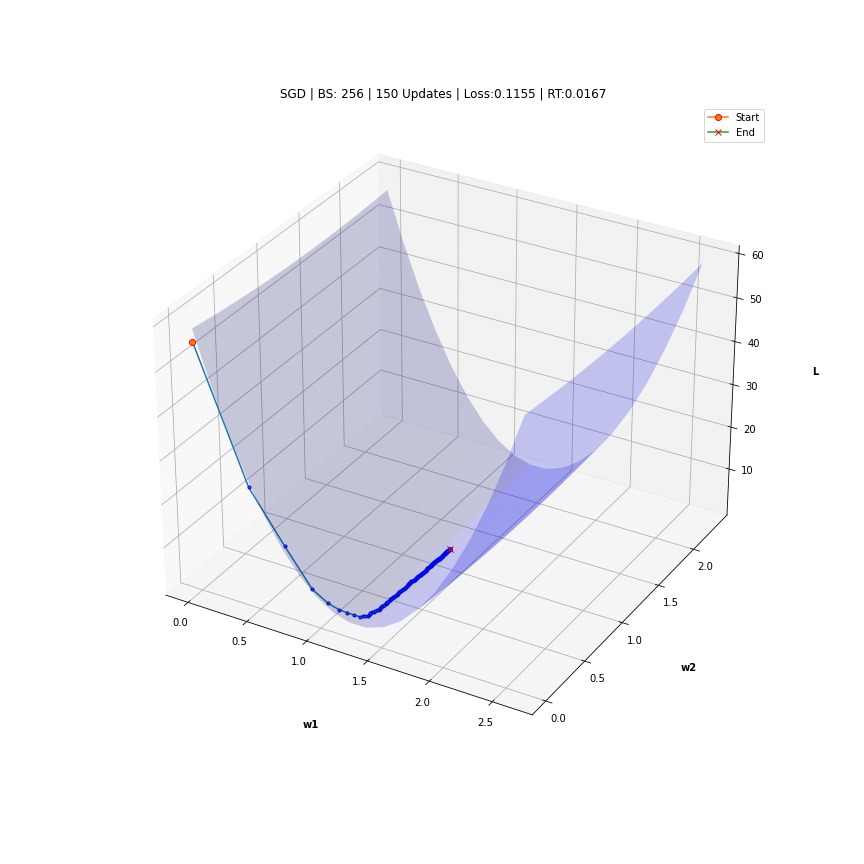

In [8]:
bs=256
all_losses,all_weights,rt= stoachastic_gradient_descent(np.column_stack( (X,np.ones(X.shape))),
                                                      np.array([[0.0],[0.0]]),
                                                      batch_size=bs,
                                                      num_update=num_update,
                                                      lr=lr)
visualize(Xaug,y,all_losses,all_weights,title=f'SGD | BS: {bs} | {num_update} Updates | Loss:{all_losses[-1]:.4f} | RT:{rt}')

# Momentum


## $$ \begin{align}
    \mathbf{v}_{t+1} &= \mu \mathbf{v}_{t} + (1-\mu) \nabla_\mathbf{w} \mathcal{L}_{\mathcal{B}} (\mathbf{w}_t) &&
    \text{Momentum Update}
    \label{eq:momentum_accumulation}\\
    \mathbf{w}_{t+1} &= \mathbf{w}_{t} -  \eta \mathbf{v}_{t+1}&&
    \text{Parameter Update with Momentum}
\end{align}
$$


<IPython.core.display.Javascript object>


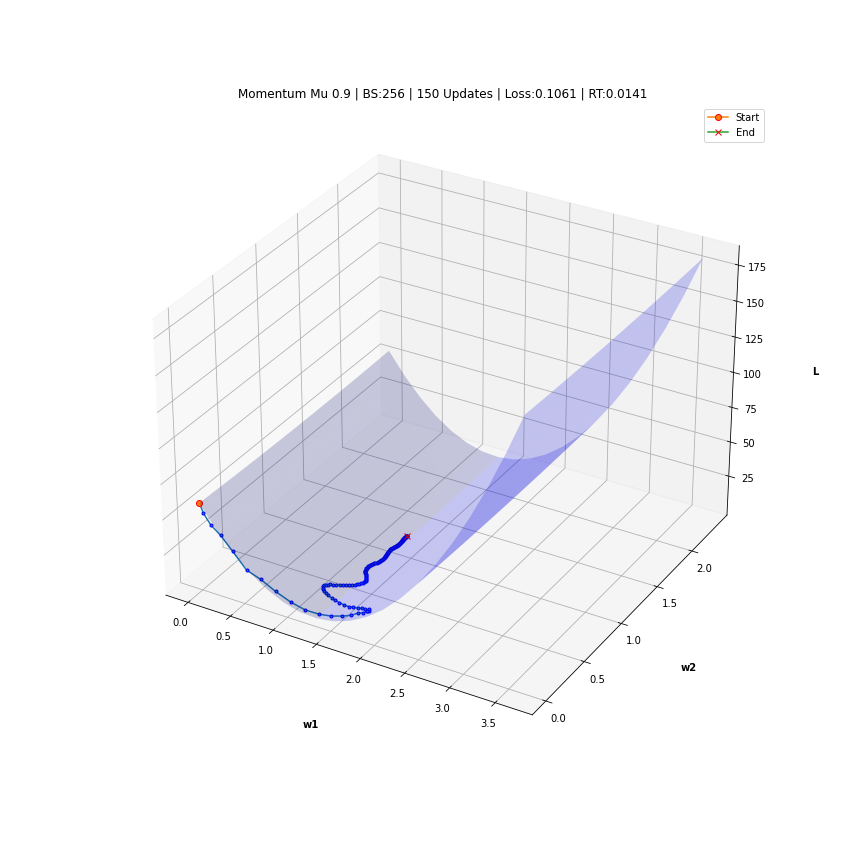

In [9]:
np.random.seed(0)
def momentum(Xaug,w,batch_size,num_update,lr,mu=0.9):
    start_time=time.time()
    all_losses=[]
    all_weights=[]
    all_predicitons= []
    # v is all zeros
    v=np.zeros(w.shape)
    N=len(Xaug)

    for i in range(num_update):
        # 1. Select random samples
        idx=np.random.randint(N, size=batch_size)
        # 2. Compute predicitons of shape N
        pred=predict(Xaug[idx],w).flatten()
        # 2. Compute residual errors of shape N
        error=residual_error(pred,y[idx])
        # 3. Compute loss; mean squared of residual errors.
        loss = L(error)# scalar
        # 4. Compute gradient of te loss w.r.t. weights. # shape d
        dw = dLdw(error,Xaug[idx])
        # 5. Store data.
        all_losses.append(loss);all_predicitons.append(pred);all_weights.append(w.flatten())
        # 6. Compute Momentum Update
        v=mu*v + (1-mu) * dw        
        w-=lr *v        
    rt=f"{time.time()- start_time:.4f}"
    return np.array(all_losses),np.array(all_weights),rt
    
mu=0.9
all_losses,all_weights,rt= momentum(np.column_stack( (X,np.ones(X.shape))),
                                                      np.array([[0.0],[0.0]]),
                                                      batch_size=bs,
                                                      num_update=num_update,
                                                      lr=lr,mu=mu)
visualize(Xaug,y,all_losses,all_weights,title=f'Momentum Mu {mu} | BS:256 | {num_update} Updates | Loss:{all_losses[-1]:.4f} | RT:{rt}')

# Nesterov's Momentum

### $$\begin{align}
    \hat{\mathbf{w}}_{t+1} &= \mathbf{w}_t - \eta\mu\mathbf{v}_{t} &&
    \text{Nesterov Look-ahead Update}
    \\
    \mathbf{v}_{t+1} &= \mu \mathbf{v}_{t} + (1-\mu) \nabla_w \mathcal{L}_{\mathcal{B}} (\hat{\mathbf{w}}_{t+1}) &&
    \text{Momentum Update}\\
    \mathbf{w}_{t+1} &= \mathbf{w}_{t} -  \eta \mathbf{v}_{t+1}&&
    \text{Parameter Update with Momentum}
\end{align}
$$



<IPython.core.display.Javascript object>


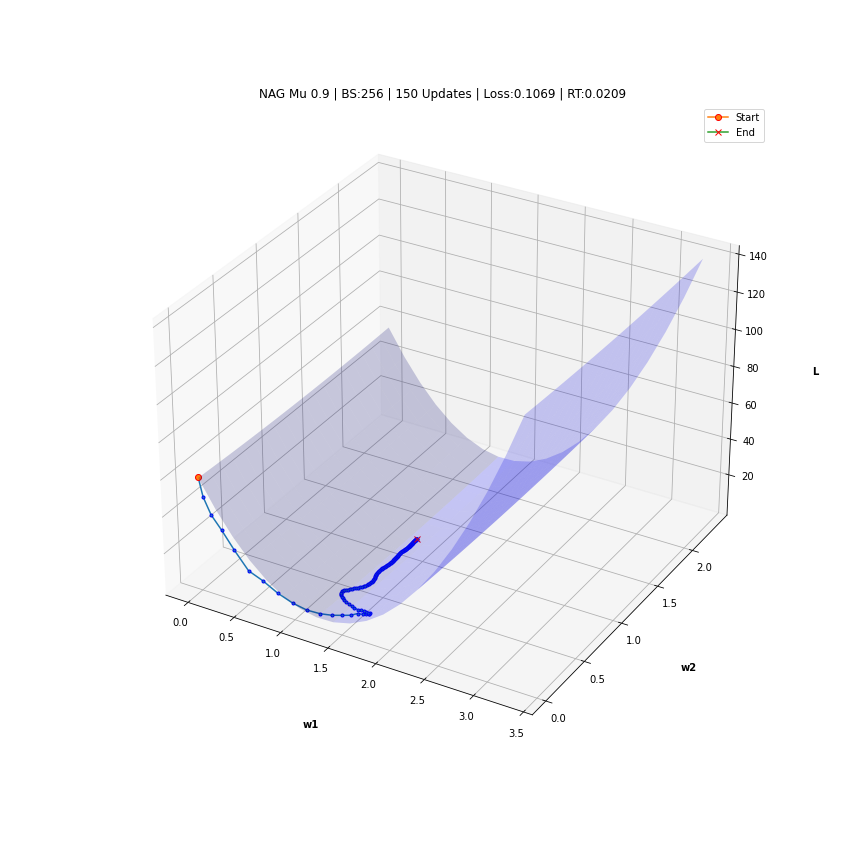

In [10]:
np.random.seed(0)
def nesterov_momentum(Xaug,w,batch_size,num_update,lr,mu):
    start_time=time.time()
    all_losses,all_weights,all_predicitons=[],[],[]
    v=np.zeros(w.shape)
    N=len(Xaug)

    for i in range(num_update):
        # 1. Select random samples
        idx=np.random.randint(N, size=batch_size)
        # 2. Nesterov Look-head Update
        headw = w - lr*mu*v
        # 3. Compute predicitons of shape N
        pred=predict(Xaug[idx],headw).flatten()
        # 4. Compute residual errors of shape N
        error=residual_error(pred,y[idx])
        # 5. Compute loss; mean squared of residual errors.
        loss = L(error)# scalar
        # 6. Compute gradient of te loss w.r.t. weights. # shape d
        dw = dLdw(error,Xaug[idx])
        # 7. Store data.
        all_losses.append(loss);all_predicitons.append(pred);all_weights.append(w.flatten())
        # 8. Compute Momentum
        v=mu*v + (1-mu)*dw
        w-=lr*v
    rt=f"{time.time()- start_time:.4f}"
    return np.array(all_losses),np.array(all_weights),rt

all_losses,all_weights,rt= nesterov_momentum(np.column_stack( (X,np.ones(X.shape))),
                                                      np.array([[0.0],[0.0]]),
                                                      batch_size=bs,
                                                      num_update=num_update,
                                                      lr=lr,mu=mu)
visualize(Xaug,y,all_losses,all_weights,title=f'NAG Mu {mu} | BS:{bs} | {num_update} Updates | Loss:{all_losses[-1]:.4f} | RT:{rt}')

# RMSPROP 
### $$\begin{align}
    \mathbf{u}_{t+1} &= \mu \mathbf{u}_t + (1-\mu) \big(\nabla_\mathbf{w} \mathcal{L}_\mathcal{B} (\mathbf{w}_t) \circ \nabla_\mathbf{w} \mathcal{L}_\mathcal{B} (\mathbf{w}_t) \big) &&
    \text{Moving Avg. of Sq. Grads.}\\
    \mathbf{w}_{t+1} &= \mathbf{w}_{t} -  \eta \frac{\nabla_\mathbf{w} \mathcal{L}_\mathcal{B} (\mathbf{w}_t)}{\sqrt{\mathbf{u}_{t+1}} + \epsilon}&&
    \text{Parameter Update}
    \label{eq:rmsprob_update}
\end{align}$$

<IPython.core.display.Javascript object>


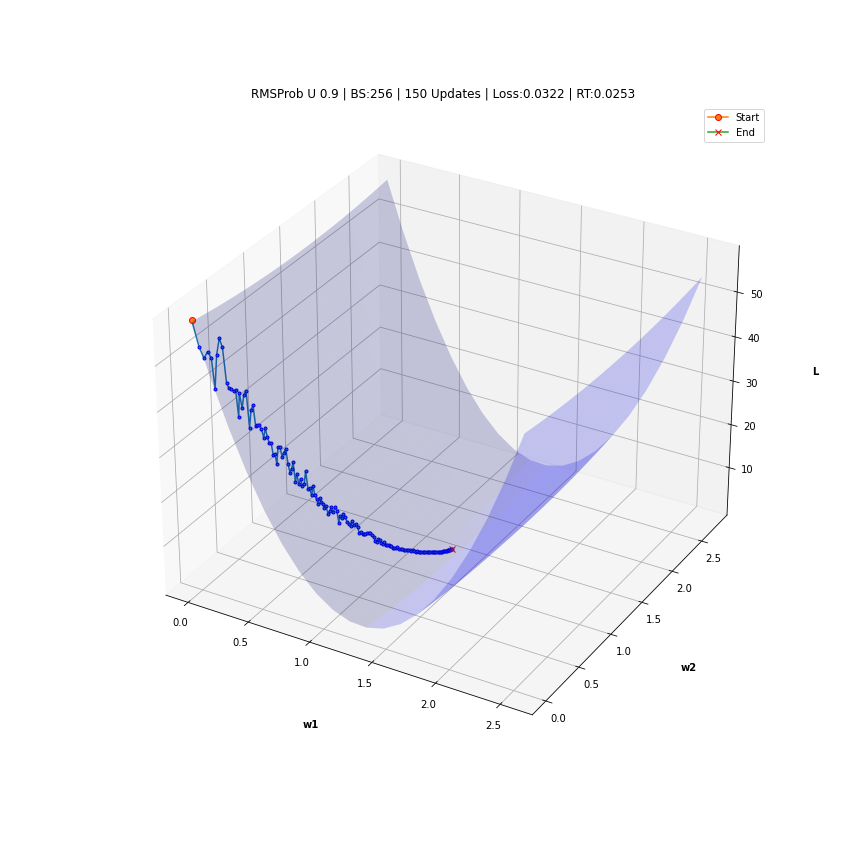

In [11]:
np.random.seed(0)
def rmpsprob(Xaug,w,batch_size,num_update,lr,mu):
    start_time=time.time()
    all_losses,all_weights,all_predicitons=[],[],[]
    u=np.zeros(w.shape)
    N=len(Xaug)

    for i in range(num_update):
        # 1. Select random samples
        idx=np.random.randint(N, size=batch_size)
        # 2. Compute predicitons of shape N
        pred=predict(Xaug[idx],w).flatten()
        # 3. Compute residual errors of shape N
        error=residual_error(pred,y[idx])
        # 4. Compute loss; mean squared of residual errors.
        loss = L(error)# scalar
        # 5. Compute gradient of te loss w.r.t. weights. # shape d
        dw = dLdw(error,Xaug[idx])
        # 6. Store data.
        all_losses.append(loss);all_predicitons.append(pred);all_weights.append(w.flatten())
        # 8. Update
        
        u=mu*u + (1-mu)*(dw*dw)
        
        w-=lr*(dw/(np.sqrt(u)+0.000001))
    rt=f"{time.time()- start_time:.4f}"
    return np.array(all_losses),np.array(all_weights),rt

all_losses,all_weights,rt= rmpsprob(np.column_stack( (X,np.ones(X.shape))),
                                                      np.array([[0.0],[0.0]]),
                                                      batch_size=bs,
                                                      num_update=num_update,
                                                      lr=lr,mu=mu)
visualize(Xaug,y,all_losses,all_weights,title=f'RMSProb U {mu} | BS:{bs} | {num_update} Updates | Loss:{all_losses[-1]:.4f} | RT:{rt}')

## ADAM


### $$\begin{align}
    \hat{\mathbf{v}}_{t+1} &= \mu \mathbf{v}_{t} + (1-\mu) \nabla_{\mathbf{w}} \mathcal{L}_{\mathcal{B}} (\mathbf{w}_t) && \text{Momentum}\\
    \mathbf{v}_{t+1} &= \frac{\hat{\mathbf{v}}_{t+1}}{1-\mu^{t+1}}
    && \text{Bias Correction}\\
    \hat{\mathbf{u}}_{t+1} &= \beta \mathbf{u}_{t} + (1-\beta) \big(\nabla_\mathbf{w} \mathcal{L}_\mathcal{B} (\mathbf{w}_t) \circ \nabla_\mathbf{w} \mathcal{L}_\mathcal{B} (\mathbf{w}_t) \big)&& \text{RMBSprob}\\
    \mathbf{u}_{t+1} &= \frac{\hat{\mathbf{u}}_{t+1}}{1-\beta^{t+1}}
    && \text{Bias Correction}\\
    \mathbf{w}_{t+1} &= \mathbf{w}_{t} - \eta \frac{\mathbf{v}_{t+1}}{\sqrt{\mathbf{u}_{t+1}}+\epsilon} && \text{Parameter Update}
    \label{eq:adam}
\end{align}$$